In [5]:
#cd /path/to/deepsurvk
#python3 -m venv venv1
#source venv1/bin/activate

#pip3 install jupyter ipykernel
#python3 -m ipykernel install --user --name=venv1 --display-name="Python (venv1)"

!pip3 install tensorflow numpy scikit-learn lifelines h5py

  Using cached tensorflow-2.19.0-cp39-cp39-macosx_12_0_arm64.whl (252.5 MB)
     |████████████████████████████████| 11.1 MB 79 kB/s eta 0:00:012
     |████████████████████████████████| 349 kB 706 kB/s eta 0:00:01
     |████████████████████████████████| 2.9 MB 344 kB/s eta 0:00:01
     |████████████████████████████████| 25.8 MB 103 kB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 612 kB/s eta 0:00:01
     |████████████████████████████████| 71 kB 397 kB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 67 kB/s eta 0:00:011
     |████████████████████████████████| 3.5 MB 294 kB/s eta 0:00:01
     |████████████████████████████████| 417 kB 522 kB/s eta 0:00:01
     |████████████████████████████████| 667 kB 573 kB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 471 kB/s eta 0:00:01
     |████████████████████████████████| 57 kB 480 kB/s eta 0:00:01
     |████████████████████████████████| 135 kB 612 kB/s eta 0:00:01
  Using cached wrapt-1.17.2-cp39-cp39-m


# 00 - Understanding DeepSurv (using Keras)
Before anything else, it makes sense to spend some time in understanding
how the original DeepSurv works. In this notebook, we take an example dataset
and go step by step through the algorithm. Please note that the code 
here was written with clarity over performance in mind.

## Preliminaries

Import packages

In [1]:
import pathlib
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, ActivityRegularization
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2

from lifelines import utils
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import h5py

/Users/Narges/Desktop/Career/_SA/deepsurvk/venv1/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Define paths.

In [2]:
example_file = '00_understanding_deepsurv'
PATH_DATA = pathlib.Path(r'../deepsurvk/datasets/data')
PATH_MODELS = pathlib.Path('./models/')

# Make sure data directory exists.
if not PATH_DATA.exists():
    raise ValueError(f"The directory {PATH_DATA} does not exist.")

# If models directory does not exist, create it.
if not PATH_MODELS.exists():
    print("Creating models directory in " + str(PATH_MODELS) + "...\t", end="", flush=True)
    PATH_MODELS.mkdir(parents=True)
    print("DONE!")
    


## Get data
In this case, we will use the Worcester Heart Attack Study (WHAS) dataset.
For a more detailed description about it, please see the corresponding
[README](../data/README.md).

In [3]:
path_data_file = PATH_DATA/'whas.h5'

# Read training data.
with h5py.File(path_data_file, 'r') as f:
    X_train = f['train']['x'][()]
    E_train = f['train']['e'][()]
    Y_train = f['train']['t'][()].reshape(-1, 1)


# Read testing data.
with h5py.File(path_data_file, 'r') as f:
    X_test = f['test']['x'][()]
    E_test = f['test']['e'][()]
    Y_test = f['test']['t'][()].reshape(-1, 1)

# Calculate important parameters.
n_patients_train = X_train.shape[0]
n_features = X_train.shape[1]

## Pre-process data
* Standardization <br>
First, we need to standardize the input (p. 3).
Notice how we only use training data for the standardization.
This done to avoid leakage (using information from
the testing partition for the model training.)

In [4]:
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

Y_scaler = StandardScaler().fit(Y_train.reshape(-1, 1))
Y_train = Y_scaler.transform(Y_train)
Y_test = Y_scaler.transform(Y_test)

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

* Sorting <br>
This is important, since we are performing a ranking task.

In [5]:
sort_idx = np.argsort(Y_train)[::-1]
X_train = X_train[sort_idx]
Y_train = Y_train[sort_idx]
E_train = E_train[sort_idx]

## Define the loss function
DeepSurv's loss function is the average negative log partial likelihood with
regularization (Eq. 4, p. 3):
   
$$l_{\theta} = -\frac{1}{N_{E=1}} \sum_{i:E_i=1} \left( \hat{h}_\theta(x_i) -\log \sum_{j \in {\rm I\!R}(T_i)} \exp^{\hat{h}_\theta(x_j)} \right) + \lambda \cdot \Vert \theta \Vert_2^2 $$

We can see that our loss function depends on three parameters:
`y_true`, `y_pred`, *and* `E`. Unfortunately, custom loss functions in Keras
[need to have their signature (i.e., prototype) as](https://keras.io/api/losses/#creating-custom-losses)
`loss_fn(y_true, y_pred)`. To overcome this, we will use a [small trick](https://github.com/keras-team/keras/issues/2121)
that is actually well known in the community. This way, we can define the 
negative log likelihood function as

In [8]:
def negative_log_likelihood(E):
    def loss(y_true, y_pred):
        
        hazard_ratio = tf.math.exp(y_pred)        
        log_risk = tf.math.log(tf.math.cumsum(hazard_ratio))
        uncensored_likelihood = tf.transpose(y_pred) - log_risk
        censored_likelihood = uncensored_likelihood * E
        neg_likelihood_ = -tf.math.reduce_sum(censored_likelihood)

        # TODO
        # For some reason, adding num_observed_events does not work.
        # Therefore, for now we will use it as a simple factor of 1.
        # Is it really needed? Isn't it just a scaling factor?
        # num_observed_events = tf.math.cumsum(E)
        # num_observed_events = tf.cast(num_observed_events, dtype=tf.float32)
        num_observed_events = tf.constant(1, dtype=tf.float32)
        
        neg_likelihood = neg_likelihood_ / num_observed_events        
        
        return neg_likelihood
    
    return loss

with regularization added further on (as part of the network architecture).

## Define model parameters
Nothing spectacular here. You can see these are pretty standard parameters.
We will use the values reported in Table 2 (p. 10).

If you decide to try a different dataset, be sure to change these
accordingly!

In [9]:
activation = 'relu'
n_nodes = 48
learning_rate = 0.067
l2_reg = 16.094
dropout = 0.147
lr_decay =  6.494e-4
momentum = 0.863


## Model construction
Now we can build the model. We will do this using the `Sequential` 
constructor, thus adding layer by layer.

The initialization of the nodes weights can be done in many different
ways. In the original DeepSurv implementation, they used [Glorot
with weights sampled from the uniform distribution](https://github.com/jaredleekatzman/DeepSurv/blob/198bb2375ea2d2cad93e568ffc550889366494ef/deepsurv/deep_surv.py#L78),
as proposed by [Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf).
Therefore, we will stick with that initialization as well.

Notice that this architecture works for the sample dataset (WHAS).
It is slightly different for each dataset (mainly the optimizer and 
number of hidden layers).

In [10]:
# Create model
model = Sequential()
model.add(Dense(units=n_features, activation=activation, kernel_initializer='glorot_uniform', input_shape=(n_features,)))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=n_nodes, activation=activation, kernel_initializer='glorot_uniform'))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='linear', kernel_initializer='glorot_uniform', kernel_regularizer=l2(l2_reg)))
model.add(ActivityRegularization(l2=l2_reg))

# Define the optimizer
# Nadam is Adam + Nesterov momentum
# optimizer = Nadam(learning_rate=learning_rate, decay=lr_decay, clipnorm=1) 
optimizer = Nadam(learning_rate=learning_rate, decay=lr_decay)

# Compile the model and show a summary of it
model.compile(loss=negative_log_likelihood(E_train), optimizer=optimizer)
model.summary()

/Users/Narges/Desktop/Career/_SA/deepsurvk/venv1/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/Narges/Desktop/Career/_SA/deepsurvk/venv1/lib/python3.9/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6)              │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │           336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 48)             │         2,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            49 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activity_regularization         │ (None, 1)              │             0 │
│ (ActivityRegularization)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,779 (10.86 KB)

 Trainable params: 2,779 (10.86 KB)

 Non-trainable params: 0 (0.00 B)

Sometimes, the computation of the loss yields a `NaN`, which makes the whole
output be `NaN` as well. I haven't identified a pattern, actually I think
it is quite random. This could be due to a variety of reasons, including
model parametrization (however, I don't really want to use different 
parameters than those reported), maybe even unfortunate parameter 
initialization. Therefore, we will use a technique called "Early Stopping".

In this case, we will train the model until the number of epochs is reached
*or* until the loss is an `NaN`. After that, training is stopped. Then,
we will selected and use the model that yielded the smallest lost.

We can achieve this very easily using [callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)

In [11]:
callbacks = [tf.keras.callbacks.TerminateOnNaN(),
             tf.keras.callbacks.ModelCheckpoint(str(PATH_MODELS/f'{example_file}.h5'), monitor='loss', save_best_only=True, mode='min')]

## Model fitting
Now we can fit the DeepSurv model. Notice how we use the whole set of 
patients in a batch. Furthermore, be sure that `shuffle` is set to `False`, 
since order is important in predicting ranked survival.

In [12]:
epochs = 1000
history = model.fit(X_train, Y_train, 
                    batch_size=n_patients_train, 
                    epochs=epochs, 
                    callbacks=callbacks,
                    shuffle=False,
                    verbose=-1)

Epoch 1/1000


Epoch 2/1000


Epoch 3/1000
Epoch 4/1000


Epoch 5/1000


Epoch 6/1000


Epoch 7/1000
Epoch 8/1000


Epoch 9/1000
Epoch 10/1000
Epoch 11/1000


Epoch 12/1000
Epoch 13/1000
Epoch 14/1000


Epoch 15/1000
Epoch 16/1000
Epoch 17/1000


Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000


Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000


Epoch 30/1000


Epoch 31/1000
Epoch 32/1000


Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000


Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000


Epoch 44/1000
Epoch 45/1000


Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000


Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000


Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
Epoch 73/1000
Epoch 74/1000
Epoch 75/1000
Epoch 76/1000
Epoch 77/1000
Epoch 78/1000


Epoch 79/1000
Epoch 80/1000
Epoch 81/1000


Epoch 82/1000
Epoch 83/1000
Epoch 84/1000
Epoch 85/1000
Epoch 86/1000
Epoch 87/1000
Epoch 88/1000
Epoch 89/1000
Epoch 90/1000
Epoch 91/1000
Epoch 92/1000
Epoch 93/1000
Epoch 94/1000
Epoch 95/1000
Epoch 96/1000
Epoch 97/1000
Epoch 98/1000
Epoch 99/1000
Epoch 100/1000
Epoch 101/1000
Epoch 102/1000
Epoch 103/1000
Epoch 104/1000
Epoch 105/1000
Epoch 106/1000
Epoch 107/1000
Epoch 108/1000
Epoch 109/1000
Epoch 110/1000
Epoch 111/1000
Epoch 112/1000
Epoch 113/1000
Epoch 114/1000
Epoch 115/1000
Epoch 116/1000
Epoch 117/1000
Epoch 118/1000


Epoch 119/1000
Epoch 120/1000
Epoch 121/1000


Epoch 122/1000
Epoch 123/1000
Epoch 124/1000
Epoch 125/1000
Epoch 126/1000
Epoch 127/1000
Epoch 128/1000
Epoch 129/1000
Epoch 130/1000
Epoch 131/1000
Epoch 132/1000
Epoch 133/1000
Epoch 134/1000
Epoch 135/1000
Epoch 136/1000
Epoch 137/1000
Epoch 138/1000
Epoch 139/1000
Epoch 140/1000
Epoch 141/1000
Epoch 142/1000
Epoch 143/1000
Epoch 144/1000
Epoch 145/1000
Epoch 146/1000
Epoch 147/1000
Epoch 148/1000
Epoch 149/1000
Epoch 150/1000
Epoch 151/1000
Epoch 152/1000
Epoch 153/1000
Epoch 154/1000
Epoch 155/1000
Epoch 156/1000
Epoch 157/1000
Epoch 158/1000
Epoch 159/1000
Epoch 160/1000
Epoch 161/1000
Epoch 162/1000
Epoch 163/1000
Epoch 164/1000
Epoch 165/1000
Epoch 166/1000
Epoch 167/1000
Epoch 168/1000
Epoch 169/1000
Epoch 170/1000
Epoch 171/1000
Epoch 172/1000
Epoch 173/1000
Epoch 174/1000
Epoch 175/1000
Epoch 176/1000
Epoch 177/1000
Epoch 178/1000
Epoch 179/1000
Epoch 180/1000
Epoch 181/1000
Epoch 182/1000
Epoch 183/1000
Epoch 184/1000
Epoch 185/1000
Epoch 186/1000
Epoch 187/1000


Epoch 188/1000


Epoch 189/1000
Epoch 190/1000
Epoch 191/1000
Epoch 192/1000


Epoch 193/1000
Epoch 194/1000
Epoch 195/1000
Epoch 196/1000
Epoch 197/1000
Epoch 198/1000
Epoch 199/1000
Epoch 200/1000


Epoch 201/1000
Epoch 202/1000
Epoch 203/1000
Epoch 204/1000
Epoch 205/1000
Epoch 206/1000
Epoch 207/1000
Epoch 208/1000
Epoch 209/1000
Epoch 210/1000
Epoch 211/1000
Epoch 212/1000
Epoch 213/1000
Epoch 214/1000
Epoch 215/1000
Epoch 216/1000
Epoch 217/1000
Epoch 218/1000
Epoch 219/1000
Epoch 220/1000
Epoch 221/1000
Epoch 222/1000
Epoch 223/1000
Epoch 224/1000
Epoch 225/1000


Epoch 226/1000
Epoch 227/1000
Epoch 228/1000
Epoch 229/1000
Epoch 230/1000
Epoch 231/1000
Epoch 232/1000
Epoch 233/1000
Epoch 234/1000
Epoch 235/1000
Epoch 236/1000
Epoch 237/1000
Epoch 238/1000
Epoch 239/1000
Epoch 240/1000
Epoch 241/1000
Epoch 242/1000
Epoch 243/1000
Epoch 244/1000
Epoch 245/1000
Epoch 246/1000
Epoch 247/1000
Epoch 248/1000
Epoch 249/1000
Epoch 250/1000
Epoch 251/1000
Epoch 252/1000
Epoch 253/1000
Epoch 254/1000
Epoch 255/1000
Epoch 256/1000
Epoch 257/1000
Epoch 258/1000
Epoch 259/1000
Epoch 260/1000
Epoch 261/1000
Epoch 262/1000
Epoch 263/1000
Epoch 264/1000
Epoch 265/1000
Epoch 266/1000
Epoch 267/1000
Epoch 268/1000
Epoch 269/1000
Epoch 270/1000
Epoch 271/1000


Epoch 272/1000
Epoch 273/1000


Epoch 274/1000
Epoch 275/1000


Epoch 276/1000
Epoch 277/1000
Epoch 278/1000
Epoch 279/1000
Epoch 280/1000
Epoch 281/1000
Epoch 282/1000
Epoch 283/1000
Epoch 284/1000
Epoch 285/1000
Epoch 286/1000
Epoch 287/1000
Epoch 288/1000
Epoch 289/1000
Epoch 290/1000
Epoch 291/1000
Epoch 292/1000
Epoch 293/1000
Epoch 294/1000
Epoch 295/1000


Epoch 296/1000
Epoch 297/1000
Epoch 298/1000
Epoch 299/1000
Epoch 300/1000
Epoch 301/1000
Epoch 302/1000
Epoch 303/1000
Epoch 304/1000
Epoch 305/1000
Epoch 306/1000
Epoch 307/1000
Epoch 308/1000
Epoch 309/1000
Epoch 310/1000
Epoch 311/1000
Epoch 312/1000
Epoch 313/1000
Epoch 314/1000
Epoch 315/1000
Epoch 316/1000
Epoch 317/1000
Epoch 318/1000
Epoch 319/1000
Epoch 320/1000
Epoch 321/1000
Epoch 322/1000
Epoch 323/1000
Epoch 324/1000
Epoch 325/1000
Epoch 326/1000
Epoch 327/1000
Epoch 328/1000
Epoch 329/1000
Epoch 330/1000
Epoch 331/1000
Epoch 332/1000
Epoch 333/1000
Epoch 334/1000
Epoch 335/1000
Epoch 336/1000
Epoch 337/1000
Epoch 338/1000
Epoch 339/1000
Epoch 340/1000
Epoch 341/1000
Epoch 342/1000
Epoch 343/1000
Epoch 344/1000
Epoch 345/1000
Epoch 346/1000
Epoch 347/1000
Epoch 348/1000
Epoch 349/1000
Epoch 350/1000
Epoch 351/1000
Epoch 352/1000
Epoch 353/1000
Epoch 354/1000
Epoch 355/1000
Epoch 356/1000
Epoch 357/1000
Epoch 358/1000
Epoch 359/1000
Epoch 360/1000
Epoch 361/1000
Epoch 362/

Epoch 368/1000
Epoch 369/1000
Epoch 370/1000
Epoch 371/1000
Epoch 372/1000
Epoch 373/1000
Epoch 374/1000


Epoch 375/1000
Epoch 376/1000
Epoch 377/1000
Epoch 378/1000
Epoch 379/1000
Epoch 380/1000
Epoch 381/1000
Epoch 382/1000
Epoch 383/1000
Epoch 384/1000
Epoch 385/1000
Epoch 386/1000
Epoch 387/1000
Epoch 388/1000
Epoch 389/1000
Epoch 390/1000
Epoch 391/1000
Epoch 392/1000
Epoch 393/1000
Epoch 394/1000
Epoch 395/1000
Epoch 396/1000
Epoch 397/1000
Epoch 398/1000
Epoch 399/1000
Epoch 400/1000
Epoch 401/1000
Epoch 402/1000
Epoch 403/1000
Epoch 404/1000
Epoch 405/1000
Epoch 406/1000
Epoch 407/1000
Epoch 408/1000
Epoch 409/1000
Epoch 410/1000
Epoch 411/1000
Epoch 412/1000
Epoch 413/1000
Epoch 414/1000


Epoch 415/1000
Epoch 416/1000
Epoch 417/1000
Epoch 418/1000
Epoch 419/1000
Epoch 420/1000
Epoch 421/1000
Epoch 422/1000
Epoch 423/1000
Epoch 424/1000
Epoch 425/1000
Epoch 426/1000
Epoch 427/1000
Epoch 428/1000
Epoch 429/1000
Epoch 430/1000
Epoch 431/1000
Epoch 432/1000
Epoch 433/1000
Epoch 434/1000
Epoch 435/1000
Epoch 436/1000
Epoch 437/1000
Epoch 438/1000
Epoch 439/1000
Epoch 440/1000
Epoch 441/1000
Epoch 442/1000
Epoch 443/1000
Epoch 444/1000
Epoch 445/1000
Epoch 446/1000
Epoch 447/1000
Epoch 448/1000
Epoch 449/1000
Epoch 450/1000
Epoch 451/1000
Epoch 452/1000
Epoch 453/1000
Epoch 454/1000
Epoch 455/1000
Epoch 456/1000
Epoch 457/1000
Epoch 458/1000
Epoch 459/1000
Epoch 460/1000
Epoch 461/1000
Epoch 462/1000
Epoch 463/1000
Epoch 464/1000
Epoch 465/1000
Epoch 466/1000
Epoch 467/1000
Epoch 468/1000
Epoch 469/1000
Epoch 470/1000
Epoch 471/1000
Epoch 472/1000
Epoch 473/1000
Epoch 474/1000
Epoch 475/1000
Epoch 476/1000
Epoch 477/1000
Epoch 478/1000
Epoch 479/1000
Epoch 480/1000
Epoch 481/

We can see how the loss changed with the number of epochs.

Text(0, 0.5, 'Loss [u.a.]')

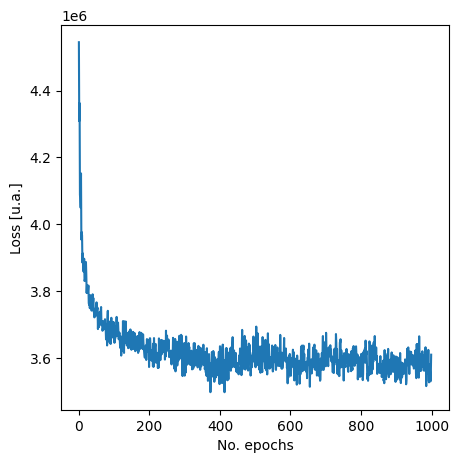

In [13]:
fig, ax = plt.subplots(1, 1, figsize=[5, 5])
plt.plot(history.history['loss'], label='train')
ax.set_xlabel("No. epochs")
ax.set_ylabel("Loss [u.a.]")

During training, we saved the model with the lowest loss value (i.e., Early Stop).
Now, we need to load it. Since we defined our own custom function,
it is important to [use the `compile=False` parameter](https://github.com/keras-team/keras/issues/5916#issuecomment-592269254).

In [14]:
model = load_model(PATH_MODELS/f'{example_file}.h5', compile=False)

## Model predictions
Finally, we can generate predictions using the DeepSurv model.

In [15]:
Y_pred_train = np.exp(-model.predict(X_train))
c_index_train = utils.concordance_index(Y_train, Y_pred_train, E_train)
print(f"c-index of training dataset = {c_index_train}")

Y_pred_test = np.exp(-model.predict(X_test))
c_index_test = utils.concordance_index(Y_test, Y_pred_test, E_test)
print(f"c-index of testing dataset = {c_index_test}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
c-index of training dataset = 0.8656654530530387
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
c-index of testing dataset = 0.842765175772692


We can see that these numbers are within the ballpark estimate of what is
reported in the original paper for this dataset (0.86-0.87, Table 1, p. 6).